In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Disable GPU

import jax
import jax.numpy as jnp
import jax.tree_util as jtu
from jax.flatten_util import ravel_pytree

import optax
# import jaxopt

import matplotlib.pyplot as plt

from gpax.core import Parameter, set_default_jitter, set_positive_bijector, get_default_jitter, get_positive_bijector
from gpax.models import ExactGPRegression, SparseGPRegression, LatentGPHeinonen, LatentGPDeltaInducing, LatentGPPlagemann
from gpax.kernels import RBF, Gibbs
from gpax.means import Scalar, Average
from gpax.likelihoods import Gaussian, Heteroscedastic
from gpax.utils import train_fn, DataScaler, add_to_diagonal
from gpax.plotting import plot_posterior
from scipy.io import loadmat, savemat
from sklearn.preprocessing import MinMaxScaler

import tensorflow_probability.substrates.jax as tfp
tfb = tfp.bijectors

import regdata as rd
from tqdm import trange

import pprint
pp = pprint.PrettyPrinter(depth=4)

is_parameter = lambda x: isinstance(x, Parameter)
set_positive_bijector(tfb.Exp())
print(get_default_jitter())

def assert_same_pytree(tree1, tree2):
    assert jtu.tree_structure(tree1) == jtu.tree_structure(tree2)
    assert jnp.all(ravel_pytree(tree1)[0] == ravel_pytree(tree2)[0])

jax.config.update("jax_enable_x64", True)
jax.__version__

latent_model = LatentGPHeinonen

1e-06


In [2]:
X_, y_, _ = rd.MotorcycleHelmet().get_data()
idx = jnp.argsort(X_[:, 0])
X_ = X_[idx]
y_ = y_[idx]

scaler = DataScaler(X_, y_)
X, y = scaler.transform(X_, y_)

In [15]:
def get_result(l,s,o,ell):
    X_inducing = X
    ell_model = latent_model(X_inducing, RBF(X_inducing, ell, 0.5).trainable(False), vmap=True)
    sigma_model = latent_model(X_inducing, RBF(X_inducing, ell, 0.5).trainable(False), vmap=False)
    likelihood_model = latent_model(X_inducing, RBF(X_inducing, ell, 0.5).trainable(False), vmap=False)

    kernel = Gibbs(X_inducing, ell_model, sigma_model, flex_ell=True, flex_sigma=True)
    likelihood = Heteroscedastic(likelihood_model)
    gp = ExactGPRegression(kernel, likelihood, Average(), X_inducing=X_inducing)
    gp.kernel.latent_model.reverse_init(l)
    gp.kernel.sigma_model.reverse_init(s)
    gp.likelihood.latent_model.reverse_init(o)
    
    def loss_fn(raw_params):
        gp.set_raw_parameters(raw_params)
        return -gp.log_probability(X, y)
    
    raw_params = gp.get_raw_parameters()
    optimizer = optax.adam(0.001)
    n_iters = 10000
    result = train_fn(loss_fn, init_raw_params=raw_params, optimizer=optimizer, n_iters=n_iters)
    
    gp.set_raw_parameters(result["raw_params"])
    return gp.log_probability(X, y, include_prior=False), gp.log_probability(X, y, include_prior=True), gp.lpd(X, y), result["raw_params"]


l = jax.random.uniform(jax.random.PRNGKey(0), minval=0.03, maxval=0.3, shape=(10,))
s = jax.random.uniform(jax.random.PRNGKey(1), minval=0.1, maxval=0.5, shape=(10,))
o = jax.random.uniform(jax.random.PRNGKey(2), minval=0.01, maxval=0.1, shape=(10,))
ell = jnp.linspace(0.1, 1.0, 10)


ll, map_ll, lpd_all, raw_params = jax.jit(jax.vmap(lambda l,s,o,ell: jax.vmap(get_result, in_axes=(0, 0, 0, None))(l,s,o,ell), in_axes=(None, None, None, 0)))(l,s,o,ell)
ll.shape

fit_term=Traced<ShapedArray(float64[])>with<JVPTrace(level=5/2)> with
  primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=3/2)>
  tangent = Traced<ShapedArray(float64[])>with<JaxprTrace(level=4/2)> with
    pval = (ShapedArray(float64[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f30ec3b0790>, in_tracers=(Traced<ShapedArray(float64[]):JaxprTrace(level=4/2)>, Traced<ShapedArray(float64[]):JaxprTrace(level=4/2)>), out_tracer_refs=[<weakref at 0x7f30c8288400; to 'JaxprTracer' at 0x7f30c8288ea0>], out_avals=[ShapedArray(float64[])], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'fn', 'donated_invars': (False, False), 'inline': True, 'keep_unused': False, 'call_jaxpr': { lambda ; a:f64[] b:f64[]. let c:f64[] = mul a b in (c,) }}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7f30ec2211f0>, name_stack=NameStack(stack=(Transform(name='jvp'),)))), penalty_term=Traced<ShapedArray(float64[]

(10, 10)

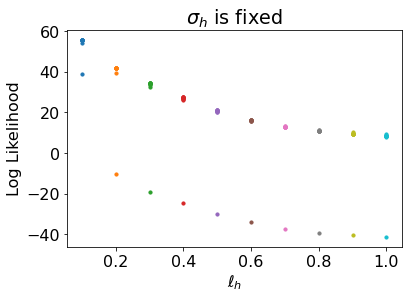

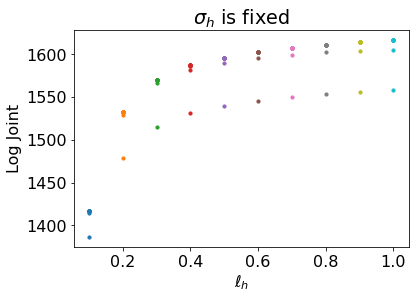

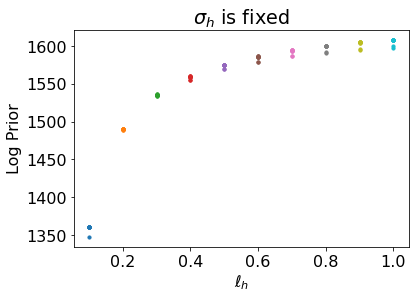

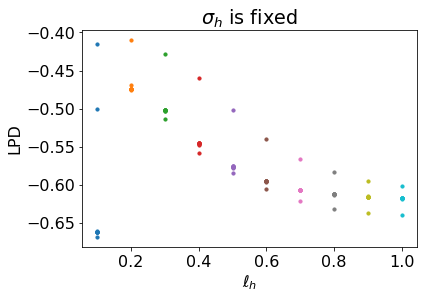

In [16]:
plt.rc("font", size=16)
plt.figure();
for ell_i, ell_x in enumerate(ell):
    plt.scatter(ell_x.repeat(ll[ell_i].size), ll[ell_i], s=10)
plt.xlabel("$\ell_h$")
plt.ylabel("Log Likelihood");
plt.title("$\sigma_h$ is fixed");

plt.figure();
for ell_i, ell_x in enumerate(ell):
    plt.scatter(ell_x.repeat(ll[ell_i].size), map_ll[ell_i], s=10)
plt.xlabel("$\ell_h$")
plt.ylabel("Log Joint");
plt.title("$\sigma_h$ is fixed");

plt.figure();
for ell_i, ell_x in enumerate(ell):
    plt.scatter(ell_x.repeat(ll[ell_i].size), map_ll[ell_i] - ll[ell_i], s=10)
plt.xlabel("$\ell_h$")
plt.ylabel("Log Prior");
plt.title("$\sigma_h$ is fixed");

plt.figure();
for ell_i, ell_x in enumerate(ell):
    plt.scatter(ell_x.repeat(ll[ell_i].size), lpd_all[ell_i], s=10)
plt.xlabel("$\ell_h$")
plt.ylabel("LPD");
plt.title("$\sigma_h$ is fixed");



In [17]:
X_inducing = X
ell_model = latent_model(X_inducing, RBF(X_inducing, ell[0], 1.0).trainable(True), vmap=True)
sigma_model = latent_model(X_inducing, RBF(X_inducing, ell[0], 1.0).trainable(True), vmap=False)
likelihood_model = latent_model(X_inducing, RBF(X_inducing, ell[0], 1.0).trainable(True), vmap=False)

kernel = Gibbs(X_inducing, ell_model, sigma_model, flex_ell=True, flex_sigma=True)
likelihood = Heteroscedastic(likelihood_model)
gp = ExactGPRegression(kernel, likelihood, Average(), X_inducing=X_inducing)

i=1j=0 fit_term=DeviceArray(-46.99921123, dtype=float64), penalty_term=DeviceArray(175.42210689, dtype=float64), log_likelihood=DeviceArray(42.04267354, dtype=float64), lpd=DeviceArray(-0.47441448, dtype=float64)
i=1j=0total_map_ll=1531.9430477471926
i=1j=1 fit_term=DeviceArray(-46.9999784, dtype=float64), penalty_term=DeviceArray(175.42858416, dtype=float64), log_likelihood=DeviceArray(42.04838364, dtype=float64), lpd=DeviceArray(-0.47460336, dtype=float64)
i=1j=1total_map_ll=1531.9430572529768
i=1j=2 fit_term=DeviceArray(-46.38507136, dtype=float64), penalty_term=DeviceArray(122.48216914, dtype=float64), log_likelihood=DeviceArray(-10.28312434, dtype=float64), lpd=DeviceArray(-0.40936956, dtype=float64)
i=1j=2total_map_ll=1478.4520578903605
i=1j=3 fit_term=DeviceArray(-47.00000767, dtype=float64), penalty_term=DeviceArray(175.42743741, dtype=float64), log_likelihood=DeviceArray(42.04720762, dtype=float64), lpd=DeviceArray(-0.47454327, dtype=float64)
i=1j=3total_map_ll=1531.9430566797

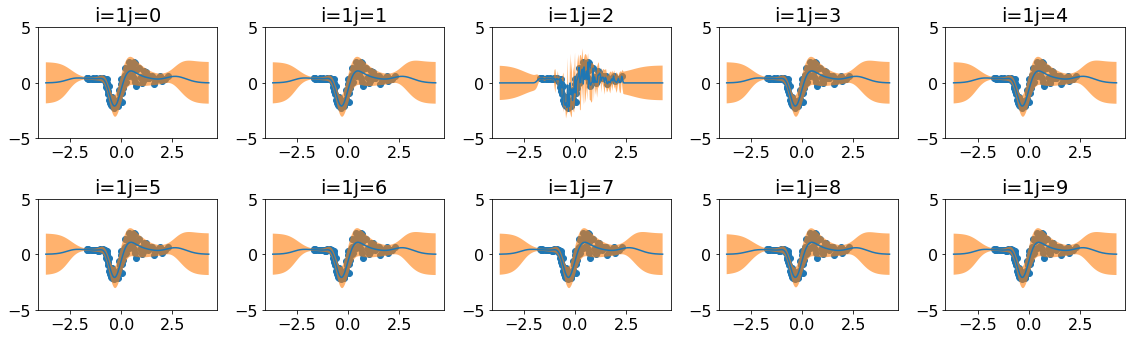

In [19]:
span = 0.5
X_test = jnp.linspace(0-span, 1+span, 200).reshape(-1, 1)
# idx = jnp.nanargmin(result["loss_history"])
# print(f"Best loss: {result['loss_history'][idx]} (iter {idx})")
# best_raw_params = jtu.tree_map(lambda x: x[idx-1], result["raw_params_history"])
i = 1
fig, ax = plt.subplots(2, 5, figsize=(16, 5))
axes = ax.flatten()
for j in range(10):
    ax = axes[j]
    best_raw_params = jtu.tree_map(lambda x: x[i][j], raw_params)
    # print(f"nlpd[{i},{j}]: {ll[i,j]}]")


    gp.set_raw_parameters(best_raw_params)
    print(f"{i=}{j=}", end=" ")
    print(f"{i=}{j=}total_map_ll={gp.log_probability(X, y, include_prior=True)}")
    trained_X_inducing = gp.X_inducing()
    pred_mean, pred_cov = gp.predict(X, y, X_test, include_noise=False)
    pred_ell = gp.kernel.latent_model(trained_X_inducing)(X_test)
    pred_sigma = gp.kernel.sigma_model(trained_X_inducing)(X_test)
    pred_omega = gp.likelihood.latent_model(trained_X_inducing)(X_test)
    pred_cov = add_to_diagonal(pred_cov, pred_omega**2, 0.0)

    (X_, X_test_, X_inducing_, trained_X_inducing_), (pred_mean_, y_), pred_ell_, pred_sigma_, pred_omega_ = scaler.inverse_transform((X, X_test, X_inducing, trained_X_inducing), (pred_mean, y), pred_ell, pred_sigma, pred_omega)
    pred_cov_ = pred_cov * scaler.y_scale**2

    ax = plot_posterior(X_, y_, X_test_, pred_mean_, pred_cov_, ax=ax, alpha=0.6);
    # ax.legend(bbox_to_anchor=(1,1));
    ax.set_ylim(-5, 5)
    ax.set_title(f"{i=}{j=}")
    # for x in X_inducing_:
    #     ax.axvline(x, color="k", alpha=0.3)

    # for x in trained_X_inducing_:
    #     ax.axvline(x, color="r", alpha=0.3)


    # plt.figure();
    # plt.plot(X_test_, pred_ell_, label='l', color='r')
    # plt.plot(X_test_, pred_sigma_, label='s', color='g')
    # plt.plot(X_test_, pred_omega_, label='o', color='b');
    # plt.legend();
fig.tight_layout()